# Recommendation Strategies Evaluation

## Overview

This notebook evaluates different recommendation strategies for the music taste recommender system. The evaluation framework:

1. **Strategy Testing**: Compare 5 different recommendation approaches (balanced, retention, discovery, conservative, aggressive)
2. **User Simulation**: Generate synthetic users with realistic listening histories and preferences  
3. **Metrics Assessment**: Measure relevance, diversity, and composite scores for each strategy
4. **Genre Analysis**: Examine performance across different music genres
5. **Visualization**: Create comparative plots and save results for further analysis

The goal is to identify which strategy provides the best balance between accuracy (relevance) and novelty (diversity) for music recommendations.

### Environment Setup & Imports

Import required libraries for data processing, visualization, and evaluation. Key components:
- **pandas/numpy**: Data manipulation and numerical operations
- **matplotlib/seaborn**: Visualization and plotting
- **tqdm**: Progress bars for long-running evaluations
- **Custom modules**: MusicRecommender, UserSimulator, and strategy configurations

Set up plotting style and default figure sizes for consistent visualization throughout the evaluation.

In [1]:
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from src.recommender import MusicRecommender
from src.user_simulator import UserSimulator
from config.business_config import STRATEGIES

sns.set_style("darkgrid")
plt.rcParams['figure.figsize'] = (14, 6)

print("✅ Imports loaded")

✅ Imports loaded


### Data Loading & Recommender Initialization

Data Sources
- **Embeddings**: Pre-computed track embeddings from audio features
- **Track IDs**: Mapping between track IDs and embedding indices  
- **Dataset**: Processed Spotify dataset with genre mappings and audio features

Recommender Setup
Initialize the MusicRecommender with the balanced strategy as default. This recommender uses content-based filtering with configurable exploration parameters.

In [2]:
EMBEDDINGS_PATH = "../data/embeddings/track_embeddings.npy"
TRACK_IDS_PATH = "../data/embeddings/track_ids.npy"
DATASET_PATH = "../data/processed/spotify_clean_balanced.csv"

# Load dataset
df = pd.read_csv(DATASET_PATH)
print(f"Dataset: {df.shape}")

# Load recommender
recommender = MusicRecommender(
    EMBEDDINGS_PATH,
    TRACK_IDS_PATH,
    DATASET_PATH,
    strategy='balanced'
)

Dataset: (217117, 18)
Loading recommendation system...
✅ System loaded:
   - 217,117 tracks
   - Strategy: Balanced
   - Weights: Relevance=0.5, Diversity=0.5


## User Simulation

### Synthetic User Generation

Create realistic user profiles for evaluation:
- **Number of users**: 500 synthetic users with diverse preferences
- **Listening history**: 20 tracks per user to simulate real usage patterns
- **Genre preference**: 70% of tracks from user's favorite genre, 30% from other genres
- **Seed**: Fixed random seed (42) for reproducible results

This approach ensures evaluation on diverse user types while maintaining computational efficiency.

In [3]:
N_USERS = 500

simulator = UserSimulator(df, seed=42)
users = simulator.generate_users(
    n_users=N_USERS,
    tracks_per_user=20,
    favorite_genre_ratio=0.7
)

print(f"\n✅ {len(users)} users generated")

Generating 500 simulated users...
✅ 500 simulated users generated

📊 Favorite Genre Distribution:
   Rock           :  105 ( 21.0%)
   Pop            :   85 ( 17.0%)
   Classical      :   74 ( 14.8%)
   Hip Hop        :   58 ( 11.6%)
   Electronic     :   39 (  7.8%)
   Soundtrack     :   37 (  7.4%)
   Country        :   35 (  7.0%)
   Jazz           :   34 (  6.8%)
   Latin          :   33 (  6.6%)

✅ 500 users generated


## Strategy Evaluation

### Evaluation Framework

Test all 5 recommendation strategies:
- **Balanced**: Moderate exploration vs exploitation
- **Retention**: Focus on user's existing preferences (conservative)
- **Discovery**: Emphasize novel recommendations (exploratory)
- **Conservative**: Minimal exploration, high relevance focus
- **Aggressive**: Maximum exploration, high diversity focus

### Metrics Collected
For each user-strategy combination:
- **Relevance**: How well recommendations match user's taste (0-1 scale)
- **Diversity**: Novelty and variety in recommendations (0-1 scale)
- **Composite Score**: Weighted combination of relevance and diversity
- **Penalty Rate**: Percentage of recommendations with quality penalties applied

### Process
- Generate 10 recommendations per user per strategy
- Evaluate each recommendation set against user's preferences
- Aggregate results across all users for statistical analysis

In [4]:
print("\n" + "="*60)
print("EVALUATING ALL STRATEGIES")
print("="*60)

strategies_to_test = ['balanced', 'retention', 'discovery', 'conservative', 'aggressive']
all_results = {}

for strategy_name in strategies_to_test:
    print(f"\n📊 Evaluating strategy: {strategy_name.upper()}")

    recommender.change_strategy(strategy_name)

    results = []

    # Evaluate with all users
    for user in tqdm(users, desc=f"{strategy_name:12s}"):
        try:
            _, metrics = recommender.recommend_for_user_history(
                user.history_track_ids,
                n_recommendations=10,
                evaluate=True
            )

            # Add user info
            metrics['user_id'] = user.user_id
            metrics['favorite_genre'] = user.favorite_genre

            results.append(metrics)
        except Exception as e:
            # Skip if error (e.g., user without valid tracks)
            continue

    all_results[strategy_name] = pd.DataFrame(results)

    # Show average metrics
    avg_metrics = all_results[strategy_name][['relevance', 'diversity', 'composite_score']].mean()
    print(f"\n   Averages:")
    print(f"   - Relevance:  {avg_metrics['relevance']:.3f}")
    print(f"   - Diversity:  {avg_metrics['diversity']:.3f}")
    print(f"   - Composite:  {avg_metrics['composite_score']:.3f}")

print("\n✅ Evaluation completed")


EVALUATING ALL STRATEGIES

📊 Evaluating strategy: BALANCED
✅ Strategy changed to: Balanced
   Weights: Relevance=0.5, Diversity=0.5


balanced    : 100%|██████████| 500/500 [26:05<00:00,  3.13s/it]



   Averages:
   - Relevance:  0.888
   - Diversity:  0.696
   - Composite:  0.792

📊 Evaluating strategy: RETENTION
✅ Strategy changed to: Retention-Focused
   Weights: Relevance=0.6, Diversity=0.4


retention   : 100%|██████████| 500/500 [22:07<00:00,  2.66s/it]



   Averages:
   - Relevance:  0.888
   - Diversity:  0.696
   - Composite:  0.811

📊 Evaluating strategy: DISCOVERY
✅ Strategy changed to: Discovery-Focused
   Weights: Relevance=0.4, Diversity=0.6


discovery   : 100%|██████████| 500/500 [21:16<00:00,  2.55s/it]



   Averages:
   - Relevance:  0.888
   - Diversity:  0.696
   - Composite:  0.772

📊 Evaluating strategy: CONSERVATIVE
✅ Strategy changed to: Conservative
   Weights: Relevance=0.7, Diversity=0.3


conservative: 100%|██████████| 500/500 [21:41<00:00,  2.60s/it]



   Averages:
   - Relevance:  0.888
   - Diversity:  0.696
   - Composite:  0.830

📊 Evaluating strategy: AGGRESSIVE
✅ Strategy changed to: Aggressive Discovery
   Weights: Relevance=0.3, Diversity=0.7


aggressive  : 100%|██████████| 500/500 [20:59<00:00,  2.52s/it]


   Averages:
   - Relevance:  0.888
   - Diversity:  0.696
   - Composite:  0.753

✅ Evaluation completed


## Results Analysis & Comparison

### Comparative Analysis

Aggregate evaluation results across all strategies:
- **Strategy descriptions**: Brief explanation of each approach
- **Average metrics**: Mean relevance, diversity, and composite scores
- **Penalty rates**: Quality control metrics showing recommendation confidence

### Ranking
Strategies are ranked by composite score (primary metric) to identify the best overall performer.

In [5]:
print("\n" + "="*70)
print("STRATEGIES COMPARISON")
print("="*70)

comparison = []

for strategy_name, results_df in all_results.items():
    strategy_info = STRATEGIES[strategy_name]

    comparison.append({
        'Strategy': strategy_name.capitalize(),
        'Description': strategy_info.description[:40] + "...",
        'Relevance': results_df['relevance'].mean(),
        'Diversity': results_df['diversity'].mean(),
        'Composite': results_df['composite_score'].mean(),
        'Penalty Rate': (results_df['penalty_applied'].sum() / len(results_df)) * 100
    })

comparison_df = pd.DataFrame(comparison)
comparison_df = comparison_df.sort_values('Composite', ascending=False)

print(comparison_df.to_string(index=False))


STRATEGIES COMPARISON
    Strategy                                 Description  Relevance  Diversity  Composite  Penalty Rate
Conservative    Comfort zone (new or sensitive users)...   0.887666   0.695567   0.830036           0.0
   Retention Prioritizes user satisfaction (lower chu...   0.887666   0.695567   0.810826           0.0
    Balanced Balance between satisfaction and explora...   0.887666   0.695567   0.791616           0.0
   Discovery Promotes catalog exploration (higher eng...   0.887666   0.695567   0.772406           0.0
  Aggressive        Maximum exploration (power users)...   0.887666   0.695567   0.753196           0.0


### Strategy Performance Visualization

Create horizontal bar charts comparing each strategy across the three key metrics:
- **Relevance**: Accuracy of recommendations (higher is better)
- **Diversity**: Novelty and variety (higher is better)
- **Composite**: Balanced performance metric (higher is better)

Strategies are sorted by performance within each metric for easy comparison.

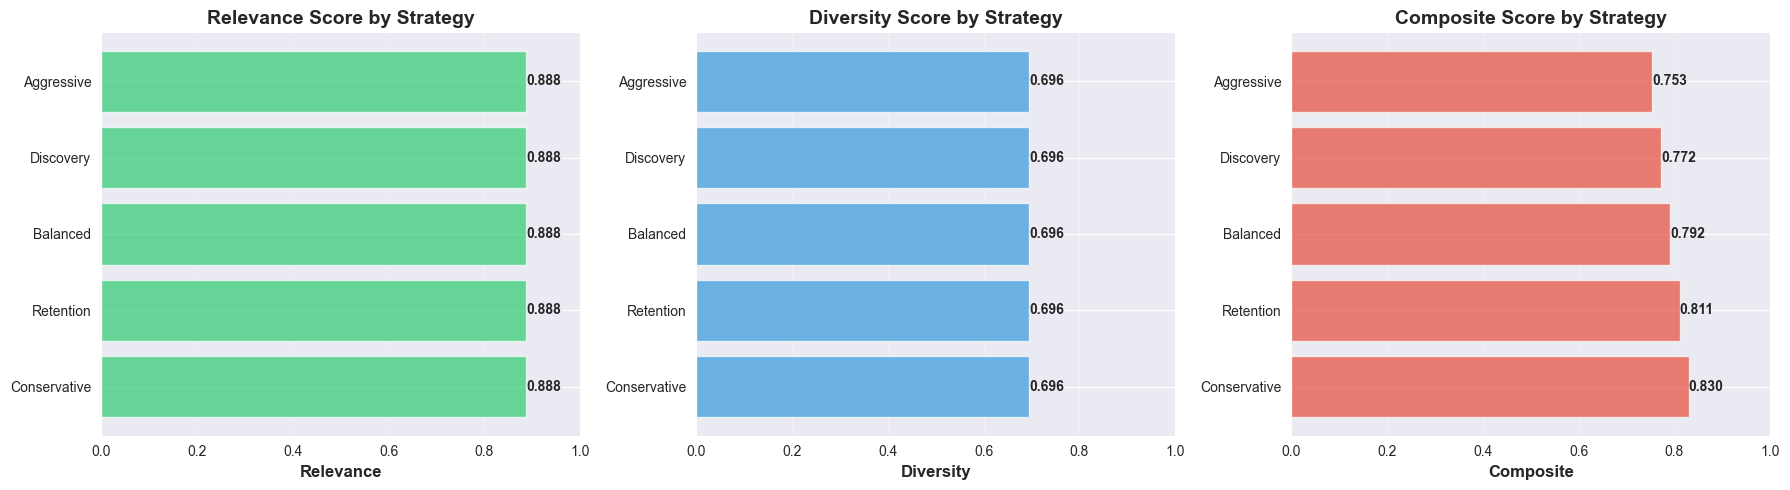

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

metrics = ['Relevance', 'Diversity', 'Composite']
colors = ['#2ecc71', '#3498db', '#e74c3c']

for idx, metric in enumerate(metrics):
    ax = axes[idx]

    data = comparison_df.sort_values(metric, ascending=False)

    bars = ax.barh(data['Strategy'], data[metric], color=colors[idx], alpha=0.7)

    # Add value labels
    for bar in bars:
        width = bar.get_width()
        ax.text(width, bar.get_y() + bar.get_height()/2,
                f'{width:.3f}',
                ha='left', va='center', fontsize=10, fontweight='bold')

    ax.set_xlabel(metric, fontsize=12, fontweight='bold')
    ax.set_xlim(0, 1)
    ax.set_title(f'{metric} Score by Strategy', fontsize=14, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

### Relevance vs Diversity Trade-off Analysis

Create scatter plots showing the relationship between relevance and diversity for each strategy:
- **X-axis**: Relevance score (user satisfaction)
- **Y-axis**: Diversity score (novelty/exploration)
- **Color**: Composite score (overall quality)
- **Reference lines**: 0.5 threshold lines for both metrics

This visualization helps understand the trade-off between accuracy and novelty across different strategies and user types.

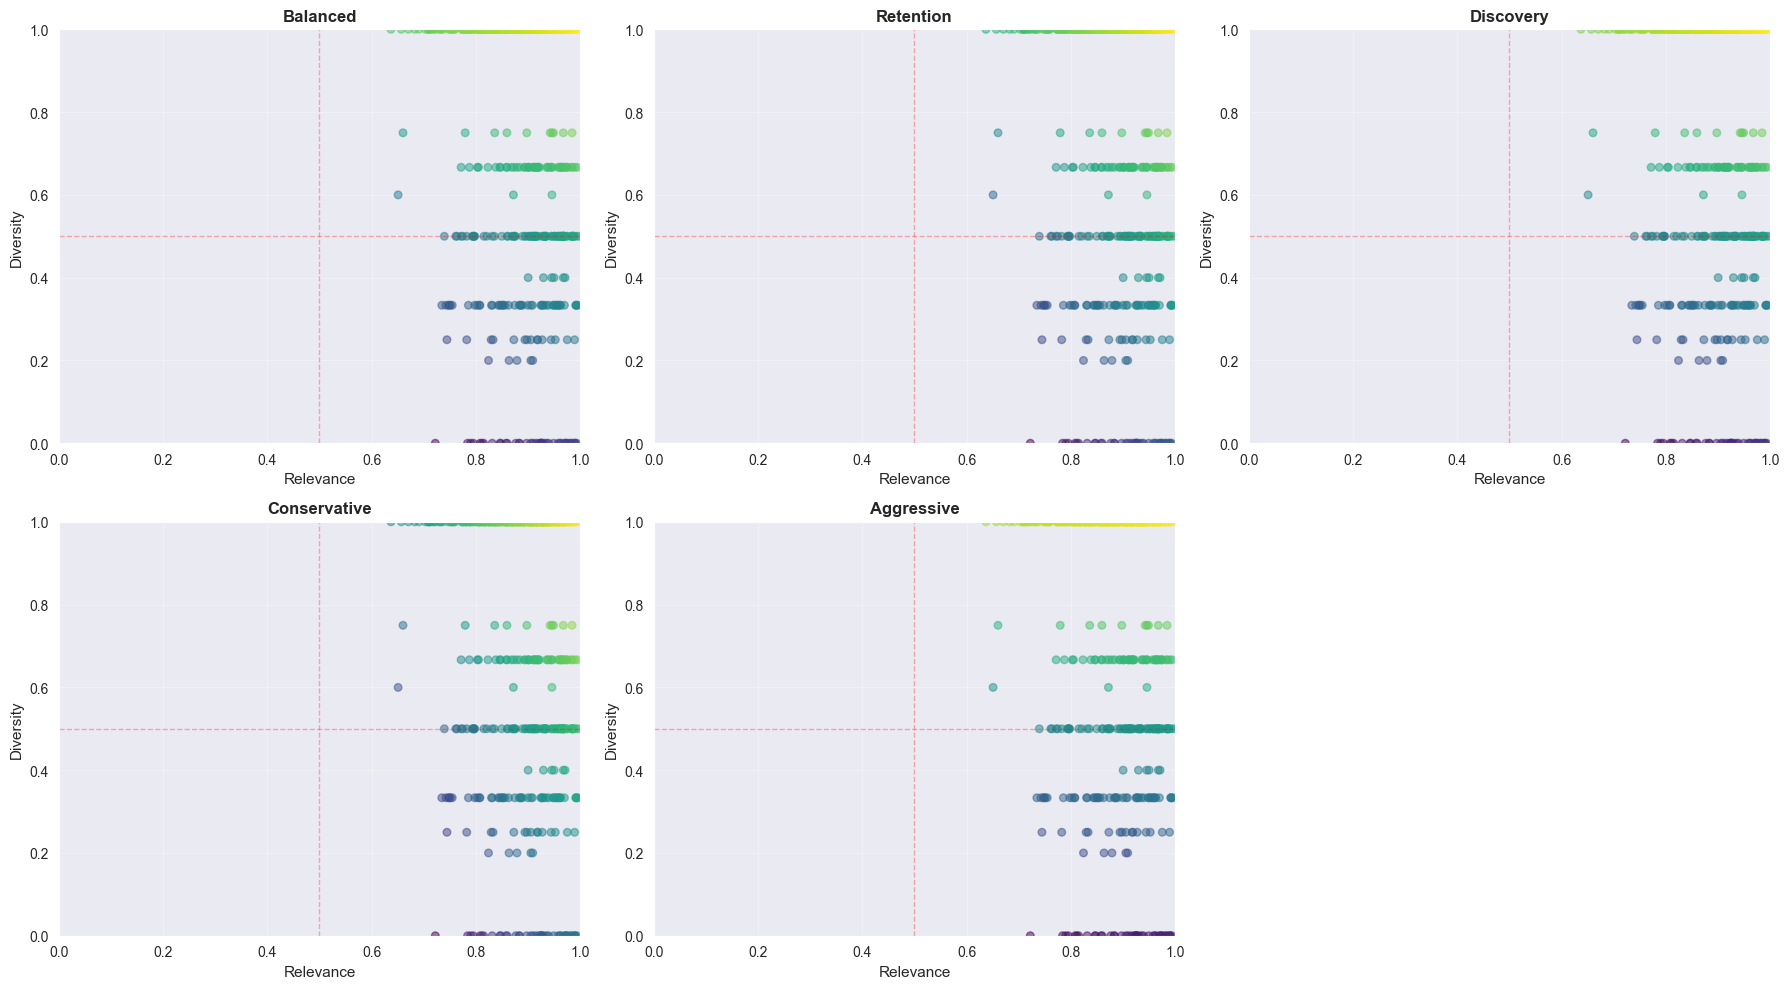

In [7]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, strategy_name in enumerate(strategies_to_test):
    ax = axes[idx]

    results_df = all_results[strategy_name]

    ax.scatter(results_df['relevance'], results_df['diversity'],
            alpha=0.5, s=30, c=results_df['composite_score'],
            cmap='viridis')

    ax.set_xlabel('Relevance', fontsize=11)
    ax.set_ylabel('Diversity', fontsize=11)
    ax.set_title(f'{strategy_name.capitalize()}', fontsize=12, fontweight='bold')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.grid(alpha=0.3)

    # Add reference lines
    ax.axhline(0.5, color='red', linestyle='--', alpha=0.3, linewidth=1)
    ax.axvline(0.5, color='red', linestyle='--', alpha=0.3, linewidth=1)

# Remove extra subplot
fig.delaxes(axes[5])

plt.tight_layout()
plt.show()

## Genre-Specific Performance Analysis

### Performance by Favorite Genre

Analyze how the balanced strategy performs across different music genres:
- **Mean and standard deviation**: Central tendency and variability for each genre
- **Cross-genre comparison**: Identify which genres are easier/harder to recommend for

This analysis reveals potential genre biases in the recommendation system and helps understand where different strategies might be more effective.


ANALYSIS BY FAVORITE GENRE (Balanced Strategy)
               relevance        diversity        composite_score       
                    mean    std      mean    std            mean    std
favorite_genre                                                         
Classical          0.945  0.036     0.601  0.293           0.773  0.147
Country            0.863  0.063     0.857  0.313           0.860  0.165
Electronic         0.843  0.052     0.585  0.399           0.714  0.200
Hip Hop            0.917  0.049     0.584  0.380           0.751  0.190
Jazz               0.876  0.052     0.772  0.348           0.824  0.175
Latin              0.895  0.053     0.772  0.288           0.834  0.141
Pop                0.872  0.074     0.736  0.328           0.804  0.167
Rock               0.850  0.091     0.796  0.282           0.823  0.146
Soundtrack         0.944  0.048     0.506  0.325           0.725  0.156


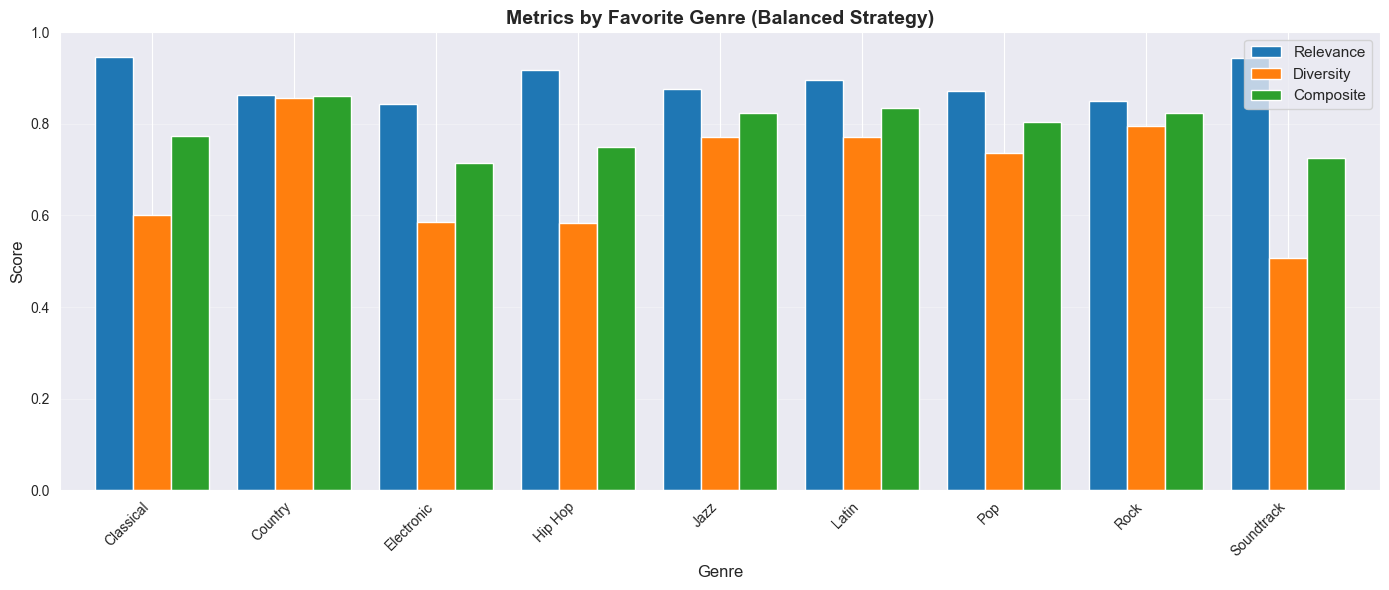

In [8]:
print("\n" + "="*70)
print("ANALYSIS BY FAVORITE GENRE (Balanced Strategy)")
print("="*70)

balanced_results = all_results['balanced']

genre_analysis = balanced_results.groupby('favorite_genre').agg({
    'relevance': ['mean', 'std'],
    'diversity': ['mean', 'std'],
    'composite_score': ['mean', 'std']
}).round(3)

print(genre_analysis)

# Visualization
genre_means = balanced_results.groupby('favorite_genre')[
    ['relevance', 'diversity', 'composite_score']
].mean()

genre_means.plot(kind='bar', figsize=(14, 6), width=0.8)
plt.title('Metrics by Favorite Genre (Balanced Strategy)', fontsize=14, fontweight='bold')
plt.xlabel('Genre', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.legend(['Relevance', 'Diversity', 'Composite'], fontsize=11)
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## Results Export & Persistence

### Saving Evaluation Results

Export all evaluation data for further analysis and reporting:
- **Individual strategy results**: Detailed metrics for each user-strategy combination
- **Comparative summary**: Aggregated performance across all strategies
- **File format**: CSV files for easy import into other analysis tools

Results are saved to `data/evaluation_results/` directory for use in downstream analysis and model comparison.

In [9]:
results_dir = Path("../data/evaluation_results")
results_dir.mkdir(parents=True, exist_ok=True)

for strategy_name, results_df in all_results.items():
    output_path = results_dir / f"{strategy_name}_results.csv"
    results_df.to_csv(output_path, index=False)
    print(f"✅ Saved: {output_path}")

# Save comparison
comparison_df.to_csv(results_dir / "strategies_comparison.csv", index=False)
print(f"✅ Saved: {results_dir / 'strategies_comparison.csv'}")

✅ Saved: ..\data\evaluation_results\balanced_results.csv
✅ Saved: ..\data\evaluation_results\retention_results.csv
✅ Saved: ..\data\evaluation_results\discovery_results.csv
✅ Saved: ..\data\evaluation_results\conservative_results.csv
✅ Saved: ..\data\evaluation_results\aggressive_results.csv
✅ Saved: ..\data\evaluation_results\strategies_comparison.csv


## Key Insights & Conclusions

**Genre Adaptation**: The system naturally adapts to different genres. Genres with more musical neighbors (Country, Rock, Jazz) achieve greater diversity without sacrificing relevance.

**Strategy Selection**: The results allow you to choose the optimal strategy according to your business objective:
- **Maximize retention** → Use “Retention”
- **Maximize discovery** → Use “Discovery”
- **Overall balance** → Use “Balanced”

Completed evaluations are saved in `data/evaluation_results/` for later analysis.